<a href="https://colab.research.google.com/github/supertime1/Floyer_Analysis/blob/main/Cosinuss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Set up dependency

In [ ]:
import sys
sys.path.append('C:/Users/57lzhang.US04WW4008/PycharmProjects/cosinuss')

In [ ]:
from data_container import config, DataFile
from data_container.api_db_sync import DBSync
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#2.Connect to Cosinuss Database

In [ ]:
def configure_api(db_name, username, update_local=False):
    """
    Configure api as the data handler
    """
    try:
        config.init(db_name=db_name)
        api = DBSync(username=username,
                    server = 'https://telecovid.earconnect.de')
    except:
        print('Configure API failed')
        return
    # password: teeshau7aiMonoh9ee
    if update_local:
    # download data from the server
        api.pull_all_dfs(prj_hash_id='M9KH')
    
    df_list_local = api.df_list(prj_hash_id='M9KH')
    print('There are', len(df_list_local), 'files in local database')
    return api


api = configure_api('sonova_analysis', 'sonova.fremont.api')

2021-02-23 15:29:53 - ERROR -       dc_config:  52 - data_container.config.init() can only be called once
2021-02-23 15:29:58 -  INFO -       api_login: 241 - login: sonova.fremont.api @ https://telecovid.earconnect.de
2021-02-23 15:30:00 -  INFO -       api_login: 253 - successful login, it expires 2021-02-24 03:30:01 expiring in 720.0 min


There are 163 files in local database


In [ ]:
def generate_table(date):
    """
    Convert local database into a Pandas dataframe, for ease of data analysis

    params:
    date: select the date that data is generated

    outputs:
    an overview table in the form of pandas dataframe
    """
    table = api.overview_dfs()
    overview_df = pd.DataFrame(table[1:], columns=table[0])
    # change to lower case for the device name
    overview_df['device'] = overview_df['device'].str.lower()
    overview_df.loc[overview_df.device.str.match(r'^polar'), 'device']= 'polar'
    overview_df = overview_df[overview_df.when > date]
    overview_df['when'] = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for 
                           i in list(overview_df['when'])]
    overview_df['duration'] = [datetime.datetime.strptime(i, '%H:%M:%S') for 
                               i in list(overview_df['duration'])]
    overview_df['end'] = [(overview_df.when.loc[i] 
                           - datetime.datetime(1900, 1, 1) 
                           + overview_df.duration.loc[i]) for i in overview_df.index]
    return overview_df

table = generate_table('2020-12-31')
print('There are', len(table), 'test records')
table.head()

There are 63 test records


,person,when,device,df id,duration,samples,cols,end
100,M9KH.BZYG (RaHe),2021-02-08 14:15:09,polar,1C2RATHBVH.C4CDEZ,1900-01-01 00:34:48,2.1 K,heart_rate,2021-02-08 14:49:57
101,M9KH.BZYG (RaHe),2021-02-08 14:15:14,cshell,1C2RATHBVH.38CD8K,1900-01-01 00:34:42,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_...",2021-02-08 14:49:56
102,M9KH.BZYG (RaHe),2021-02-08 14:15:23,cshell,1C2RATHBVH.LEMWKL,1900-01-01 00:34:36,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_...",2021-02-08 14:49:59
103,M9KH.BZYG (RaHe),2021-02-08 14:15:35,garmin,8QEK89R9B4.NZH5XL,1900-01-01 00:45:27,2.7 K,heart_rate,2021-02-08 15:01:02
104,M9KH.ME9A (LeLo),2021-02-08 15:23:00,polar,1C2RATHBVH.XCMFW1,1900-01-01 00:34:34,2.1 K,heart_rate,2021-02-08 15:57:34


In [ ]:
 def correct_label(table):
    """
    fix the labeling problem of cshell and biometric
    
    params:
    overview table from generate_table function

    outputs:
    updated table with correct cshell and biometric labels

    """
    def get_device_model(df):
        """
        get device
        
        params:
        df - output of api.pull_df
        
        outputs:
        correct device label for df
        """
        # get device
        if df.device:
            device_model = df.device.device_model
        else:
            device_model = df.device_model
        
        if 'polar' in device_model.lower():
            return 'polar'

        elif 'biomeric' in device_model.lower() or 'cshell' in device_model.lower():
            if 'ppg_ir_2' in list(df.cols):
                some_data = df.c.ppg_ir_2.y[600:650]
                if list(some_data):
                    ppg_mean = np.mean(some_data)
                else:
                    return 'na'
            else:
                ppg_mean = 1000
            
            if ppg_mean < 500:
                return 'cshell'
            else:
                return 'biometric'
    
    def get_correct_label(hash_ids, target_device):
        """

        """
        # output list of corrected labels
        corrected_name = []
        # a counter to record how many labels have been corrected after processing
        cnt = 0
        print(f'There are in total {len(hash_ids)} files with {target_device} label')
        for i in range(len(hash_ids)):
            try:
                print(f'api reading {i}th file...')
                df = api.pull_df(list(hash_ids)[i]) 
            # in case reading file failed
            except:
                print(f'api read {i}th file failed!')
                corrected_name.append(table.loc[hash_ids.index[i]].device)
                continue
            # get the new label by api reading the file
            new_label = get_device_model(df)
            corrected_name.append(new_label)
            if new_label != table.loc[hash_ids.index[i]].device:
                print(f'Person {table.loc[hash_ids.index[i]].person} and \
            {target_device} label has been corrected to {new_label}')
                cnt += 1
        print(f'There are in total {cnt} files been corrected')
        return corrected_name

    # get the hash ids of cshell and biometric in original table
    cshell_hash_ids = table[table.device == 'cshell']['df id']
    biometric_hash_ids = table[table.device == 'biometric']['df id']

    # get the row index of cshell and biometric in original table
    original_cshell_index = table[table.device == 'cshell'].index
    original_biometric_index = table[table.device == 'biometric'].index
    
    # update the original table with corrected labels of cshell and biometric
    table.device.loc[original_cshell_index] = get_correct_label(cshell_hash_ids, 
                                                     'cshell')
    table.device.loc[original_biometric_index] = get_correct_label(biometric_hash_ids, 
                                                        'biometric')

    return table

table = correct_label(table)

There are in total 32 files with cshell label
api reading 0th file...


2021-02-23 16:18:12 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.38CD8K completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


api reading 1th file...


2021-02-23 16:18:29 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.LEMWKL completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


Person M9KH.BZYG (RaHe) and            cshell label has been corrected to biometric
api reading 2th file...


2021-02-23 16:18:47 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.C4KKHL completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


Person M9KH.ME9A (LeLo) and            cshell label has been corrected to biometric
api reading 3th file...


2021-02-23 16:19:04 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.G2HHR3 completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


api reading 4th file...


2021-02-23 16:19:22 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.RG2ZUB completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


Person M9KH.03GS (DaBi) and            cshell label has been corrected to biometric
api reading 5th file...


2021-02-23 16:19:41 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.3DT9PX completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


Person M9KH.03GS (DaBi) and            cshell label has been corrected to biometric
api reading 6th file...


2021-02-23 16:19:59 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.FTZLPT completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


Person M9KH.BZYG (RaHe) and            cshell label has been corrected to biometric
api reading 7th file...


2021-02-23 16:20:16 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.95P86S completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


Person M9KH.BZYG (RaHe) and            cshell label has been corrected to biometric
api reading 8th file...


2021-02-23 16:20:34 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.DFEWY2 completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


Person M9KH.UZSF (GeSc) and            cshell label has been corrected to biometric
api reading 9th file...


2021-02-23 16:20:52 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.009DDE completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


api reading 10th file...


2021-02-23 16:21:10 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.V5BXYZ completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


api reading 11th file...


2021-02-23 16:21:28 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.XYXZQ3 completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


Person M9KH.QFUS (ZiTo) and            cshell label has been corrected to biometric
api reading 12th file...


2021-02-23 16:21:46 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.C0KF6Y completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


api reading 13th file...


2021-02-23 16:22:03 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.LBYCML completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


Person M9KH.C37E (MeBa) and            cshell label has been corrected to biometric
api reading 14th file...


2021-02-23 16:22:21 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.43ENQN completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


Person M9KH.7614 (ThHo) and            cshell label has been corrected to biometric
api reading 15th file...


2021-02-23 16:22:39 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.DYPFM1 completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


api reading 16th file...


2021-02-23 16:22:58 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.1BA6MT completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


Person M9KH.NWJR (DaBo) and            cshell label has been corrected to biometric
api reading 17th file...


2021-02-23 16:23:17 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.J5PHBD completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


Person M9KH.NWJR (DaBo) and            cshell label has been corrected to biometric
api reading 18th file...


2021-02-23 16:23:34 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.F5Q8NY completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


Person M9KH.P0J0 (AlLo) and            cshell label has been corrected to biometric
api reading 19th file...


2021-02-23 16:23:54 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.8QGMB1 completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


Person M9KH.P0J0 (AlLo) and            cshell label has been corrected to biometric
api reading 20th file...


2021-02-23 16:24:13 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.Q390R4 completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


Person M9KH.GHRN (JoKr) and            cshell label has been corrected to biometric
api reading 21th file...


2021-02-23 16:24:30 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.JYKU22 completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


api reading 22th file...


2021-02-23 16:24:47 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.8VE5T8 completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


Person M9KH.7TV5 (GrKr) and            cshell label has been corrected to biometric
api reading 23th file...


2021-02-23 16:25:04 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.N74KKE completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


api reading 24th file...


2021-02-23 16:25:21 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.9PADC8 completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


Person M9KH.SWAM (AxHe) and            cshell label has been corrected to biometric
api reading 25th file...


2021-02-23 16:25:38 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.2E4QXX completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


api reading 26th file...


2021-02-23 16:25:56 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.K7MU7Y completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


Person M9KH.F49H (RaWe) and            cshell label has been corrected to biometric
api reading 27th file...


2021-02-23 16:26:13 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.8JCMH7 completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


Person M9KH.F49H (RaWe) and            cshell label has been corrected to biometric
api reading 28th file...


2021-02-23 16:26:29 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.RPZFS4 completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


Person M9KH.3WKY (FeKo) and            cshell label has been corrected to biometric
api reading 29th file...


2021-02-23 16:26:47 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.2X8J8G completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


Person M9KH.3WKY (FeKo) and            cshell label has been corrected to biometric
api reading 30th file...


2021-02-23 16:27:04 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.9592E8 completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


Person M9KH.WSBV (NiOr) and            cshell label has been corrected to biometric
api reading 31th file...


2021-02-23 16:27:21 -  INFO -     api_db_sync: 429 - Data file 1C2RATHBVH.8HL047 completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


There are in total 22 files been corrected
There are in total 0 files with biometric label
There are in total 0 files been corrected


C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
def find_pairs_row_index(table, floyer_device='cshell'):
    """
    Filter table with paired polar and floyer devices
    """
    paired_table = table[table.device.isin(['polar', floyer_device])]
    
    paired_idx_lst = []
    # find paried sample ids
    for person in list(paired_table['person'].unique()):
        person_paired_table = paired_table[paired_table.person == person]
        polar_idx_lst = person_paired_table[person_paired_table.device == 'polar'].index
        floyer_idx_lst = person_paired_table[person_paired_table.device == floyer_device].index

        # find pairs by checking the overlapping time (2*O(n^2))
        for polar_idx in polar_idx_lst:
            polar_start_time = person_paired_table.when.loc[polar_idx]
            polar_end_time = person_paired_table.end.loc[polar_idx]

            for floyer_idx in floyer_idx_lst:
                floyer_start_time = person_paired_table.when.loc[floyer_idx]
                floyer_end_time = person_paired_table.end.loc[floyer_idx]
                
                if floyer_start_time >= polar_end_time or polar_start_time >= floyer_end_time:
                    continue
                else:
                    paired_idx_lst.append([polar_idx, floyer_idx])
    
    return paired_idx_lst

In [ ]:
find_pairs_row_index(table, floyer_device='cshell')

[[100, 101],
 [104, 106],
 [117, 116],
 [120, 121],
 [126, 124],
 [130, 128],
 [142, 141],
 [144, 146],
 [148, 150],
 [160, 162]]

In [ ]:
def generate_paired_samples(paired_idx_lst):
    """
    Use the index of paired devices (output from find_pairs_row_index) to generate
    a list of PairedSample instances

    params:
    paired_idx_lst: a list containing the row index of paired devices, 
                    It is the output of function find_pairs_row_index. 
    outputs:
    A list of PairedSample instances
    """

##Continue here

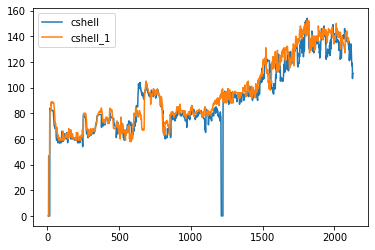

In [ ]:
cshell = api.one3_hr_algo('v0', '1C2RATHBVH.LBYCML')
cs_hr_x = np.asarray(cshell['heart_rate_t'])
cs_hr_y = cshell['heart_rate']
cd_q = cshell['quality']
plt.plot(cs_hr_x, cs_hr_y, label='cshell')

cshell1 = api.one3_hr_algo('v0', '1C2RATHBVH.C0KF6Y')
cs_hr_x_1 = np.asarray(cshell1['heart_rate_t'])
cs_hr_y_1 = cshell1['heart_rate']
cd_q1 = cshell1['quality']
plt.plot(cs_hr_x_1, cs_hr_y_1, label='cshell_1')
plt.legend()
plt.show()

In [ ]:
cshell = api.one3_hr_algo('v0', '1C2RATHBVH.LBYCML')
cs_hr_x = np.asarray(cshell['heart_rate_t'])
cs_hr_y = cshell['heart_rate']
cd_q = cshell['quality']
plt.plot(cs_hr_x, cs_hr_y)

In [ ]:
#convert time to seconds in integer
#fill
class PairedSample:
    
    def __init__(self, polar_hash_id, floyer_hash_id, hr_algo_version):
        self.polar_hash_id = polar_hash_id
        self.floyer_hash_id = floyer_hash_id
        self.df_polar = DataFile.objects(_hash_id=polar_hash_id).first()
        self.df_floyer = DataFile.objects(_hash_id=floyer_hash_id).first()
        self.hr_algo_version = hr_algo_version
    
    def process(self):
        # calculate floyer heart rate
        floyer = imp.one3_hr_algo(self.hr_algo_version, self.floyer_hash_id)
        floyer_hr_x = np.asarray(floyer['heart_rate_t'])
        floyer_hr_y = floyer['heart_rate']

        # get polar heart rate 
        po_hr_x = self.df_polar.c.heart_rate.x
        po_hr_y = self.df_polar.c.heart_rate.y

        # calculate offsets (i.e. floyer and polar maynot start recording at the
        # same time)
        offset = (df_cshell.date_time_start - 
                  df_polar.date_time_start).total_seconds() + 2098
        # make sure two devices start at the same time
        po_hr_x = po_hr_x[offset:]
        po_hr_y = po_hr_y[offset:]

        # create a new dataframe with three columns: time (s), p_hr, f_hr
        


        self.mape = self.mape() 
        self.icc = self.icc()
        self.da = self.da()

    def mape(self):
    
    def icc(self):
    
    def da(self):

    def line_plot(self):

    def ba_plot(self):

    

In [ ]:
#import polar data
df_ploar = imp.pull_df('003RN9.36G4ZN')

df_polar = DataFile.objects(_hash_id='003RN9.36G4ZN').first()
po_hr_x = df_polar.c.heart_rate.x
po_hr_y = df_polar.c.heart_rate.y
offset = (df_cshell.date_time_start - 
          df_polar.date_time_start).total_seconds() + 2098

2021-02-18 10:22:19 -  INFO -     api_db_sync: 429 - Data file 003RN9.36G4ZN completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 
